# Statistics

You may have noticed that most of the functionality in the `Hypergraph` and `SimplicialComplex` classes takes care of modifying the unerlying structure of the network, and that these classes provide very limited functionality to compute statistics (a.k.a. measures) from the network. This is done via the `stats` package, explored here.

The stats package is one of the features that sets `xgi` apart from other libraries.  It
provides a common interface to all statistics that can be computed from a network, its
nodes, or edges.

## Introduction to Stat objects

Consider the degree of the nodes of a network `H`.  After computing the values of the
degrees, one may wish to store them in a dict, a list, an array, a dataframe, etc.
Through the stats package, `xgi` provides a simple interface that seamlessly allows for
this type conversion.  This is done via the `NodeStat` class.

In [1]:
import xgi

H = xgi.Hypergraph([[1, 2, 3], [2, 3, 4, 5], [3, 4, 5]])
H.nodes.degree

NodeStat('degree')

This `NodeStat` object is essentially a wrapper over a function that computes the
degrees of all nodes.  One of the main features of `NodeStat` objects is lazy
evaluation: `H.nodes.degree` will not compute the degrees of nodes until a specific
output format is requested.

In [2]:
H.nodes.degree.asdict()

{1: 1, 2: 2, 3: 3, 4: 2, 5: 2}

In [3]:
H.nodes.degree.aslist()

[1, 2, 3, 2, 2]

In [4]:
H.nodes.degree.asnumpy()

array([1, 2, 3, 2, 2])

To compute the degrees of a subset of the nodes, call `degree` from a smaller `NodeView`.

In [5]:
H.nodes([3, 4, 5]).degree.asdict()

{3: 3, 4: 2, 5: 2}

Alternatively, to compute the degree of a single node, use square brackets.

In [6]:
H.nodes.degree[4]

2

Make sure the accessed node is in the underlying view.

In [7]:
# This will raise an exception
# because node 4 is not in the view [1, 2, 3]
#
# H.nodes([1, 2, 3]).degree[4]
#

args and kwargs may be passed to `NodeStat` objects, which will be stored and used when
the evaluation finally takes place.  For example, use the `order` keyword of `degree` to
count only those edges of the specified order.

In [8]:
H.nodes.degree(order=3)

NodeStat('degree', kwargs={'order': 3})

In [9]:
H.nodes.degree(order=3).aslist()

[0, 1, 1, 1, 1]

The stats package provides some convenience functions for numerical operations.

In [10]:
H.nodes.degree.max(), H.nodes.degree.min()

(3, 1)

In [11]:
import numpy as np

st = H.nodes([1, 2, 3]).degree(order=3)
np.round([st.max(), st.min(), st.mean(), st.median(), st.var(), st.std()], 3)

array([1.   , 0.   , 0.667, 1.   , 0.222, 0.471])

As a convenience, each node statistic may also be accessed directly through the network itself.

In [12]:
H.degree()

{1: 1, 2: 2, 3: 3, 4: 2, 5: 2}

Note however that `H.degree` is a method that simply returns a dict, not a `NodeStat` object and thus does not support the features discussed above.

## Node attributes

Node attributes can be conceived of as a node-object mapping and thus they can also be accessed using the `NodeStat` interface and all its funcitonality.

In [13]:
H.add_nodes_from(
    [
        (1, {"color": "red", "name": "horse"}),
        (2, {"color": "blue", "name": "pony"}),
        (3, {"color": "yellow", "name": "zebra"}),
        (4, {"color": "red", "name": "orangutan", "age": 20}),
        (5, {"color": "blue", "name": "fish", "age": 2}),
    ]
)

Access all attributes of all nodes by specifying a return type.

In [14]:
H.nodes.attrs.asdict()

{1: {'color': 'red', 'name': 'horse'},
 2: {'color': 'blue', 'name': 'pony'},
 3: {'color': 'yellow', 'name': 'zebra'},
 4: {'color': 'red', 'name': 'orangutan', 'age': 20},
 5: {'color': 'blue', 'name': 'fish', 'age': 2}}

Access all attributes of a single node by using square brackets.

In [15]:
H.nodes.attrs[1]

{'color': 'red', 'name': 'horse'}

Access a single attribute of all nodes by specifying a return type.

In [16]:
H.nodes.attrs("color").aslist()

['red', 'blue', 'yellow', 'red', 'blue']

If a node does not have the specified attribute, `None` will be used.

In [17]:
H.nodes.attrs("age").asdict()

{1: None, 2: None, 3: None, 4: 20, 5: 2}

Use the `missing` keyword argument to change the imputed value.

In [18]:
H.nodes.attrs("age", missing=100).asdict()

{1: 100, 2: 100, 3: 100, 4: 20, 5: 2}

## Filtering

`NodeView` objects are aware of existing `NodeStat` objects via the `filterby` method.

In [19]:
H.degree()

{1: 1, 2: 2, 3: 3, 4: 2, 5: 2}

In [20]:
H.nodes.filterby("degree", 2)  # apply the filter to all nodes

NodeView((2, 4, 5))

In [21]:
H.nodes([1, 2, 3]).filterby(
    "degree", 2
)  # apply the filter only to the subset of nodes [1, 2, 3]

NodeView((2,))

Nodes can be filtered by attribute via the `filterby_attr` method.

In [22]:
H.nodes.filterby_attr("color", "red")

NodeView((1, 4))

Since `filterby*` methods return a `NodeView` object, multiple filters can be chained, as well as other `NodeStat` calls. The following call computes the local clustering coefficient of those nodes with degree equal to 2 and "color" attribute equal to "blue", and outputs the result as a dict.

In [23]:
(
    H.nodes.filterby("degree", 2)
    .filterby_attr("color", "blue")
    .clustering_coefficient.asdict()
)

{2: 0.6666666666666666, 5: 1.0}

For example, here is how to access the nodes with maximum degree.

In [24]:
H.nodes.filterby("degree", H.nodes.degree.max())

NodeView((3,))

## Set operations

Another way of chaining multiple results of `filterby*` methods is by using set operations. Indeed, chaining two filters is the same as intersecting the results of two separate calls:

In [25]:
print(H.nodes.filterby("degree", 2).filterby_attr("color", "blue"))
print(H.nodes.filterby("degree", 2) & H.nodes.filterby_attr("color", "blue"))

[2, 5]
[2, 5]


Other set operations are also supported.

In [26]:
nodes1 = H.nodes.filterby("degree", 2)
nodes2 = H.nodes.filterby_attr("color", "blue")
print(f"nodes1 - nodes2 = {nodes1 - nodes2}")
print(f"nodes2 - nodes1 = {nodes2 - nodes1}")
print(f"nodes1 & nodes2 = {nodes1 & nodes2}")
print(f"nodes1 | nodes2 = {nodes1 | nodes2}")
print(f"nodes1 ^ nodes2 = {nodes1 ^ nodes2}")

nodes1 - nodes2 = [4]
nodes2 - nodes1 = []
nodes1 & nodes2 = [2, 5]
nodes1 | nodes2 = [2, 4, 5]
nodes1 ^ nodes2 = [4]


## Multiple statistics

One can obtain multiple node statistics at the same time via the `multi` method, which returns `MultiNodeStat` objects.

In [27]:
H.nodes.multi(["degree", "clustering_coefficient"])

MultiNodeStat(degree, clustering_coefficient)

Objects of class `MultiNodeStat` also support lazy evaluation and type conversion.

In [28]:
H.nodes.multi(["degree", "clustering_coefficient"]).asdict()

{1: {'degree': 1, 'clustering_coefficient': 1.0},
 2: {'degree': 2, 'clustering_coefficient': 0.6666666666666666},
 3: {'degree': 3, 'clustering_coefficient': 0.6666666666666666},
 4: {'degree': 2, 'clustering_coefficient': 1.0},
 5: {'degree': 2, 'clustering_coefficient': 1.0}}

There are more options for the output type of a `MultiNodeStat` object.

In [29]:
ms = H.nodes.multi(["degree", "clustering_coefficient"])

from pprint import pprint

print("# dict of dicts, nodes first:")
pprint(ms.asdict())
print()
print("# dict of dicts, stats first:")
pprint(ms.asdict(transpose=True))
print()
print("# dict of lists:")
pprint(ms.asdict(list))
print()
print("# list of lists, nodes first:")
pprint(ms.aslist())
print()
print("# list of lists, stats first:")
pprint(ms.aslist(transpose=True))
print()
print("# list of dicts:")
pprint(ms.aslist(dict))

# dict of dicts, nodes first:
{1: {'clustering_coefficient': 1.0, 'degree': 1},
 2: {'clustering_coefficient': 0.6666666666666666, 'degree': 2},
 3: {'clustering_coefficient': 0.6666666666666666, 'degree': 3},
 4: {'clustering_coefficient': 1.0, 'degree': 2},
 5: {'clustering_coefficient': 1.0, 'degree': 2}}

# dict of dicts, stats first:
{'clustering_coefficient': {1: 1.0,
                            2: 0.6666666666666666,
                            3: 0.6666666666666666,
                            4: 1.0,
                            5: 1.0},
 'degree': {1: 1, 2: 2, 3: 3, 4: 2, 5: 2}}

# dict of lists:
{1: [1, 1.0],
 2: [2, 0.6666666666666666],
 3: [3, 0.6666666666666666],
 4: [2, 1.0],
 5: [2, 1.0]}

# list of lists, nodes first:
[[1, 1.0], [2, 0.6666666666666666], [3, 0.6666666666666666], [2, 1.0], [2, 1.0]]

# list of lists, stats first:
[[1, 2, 3, 2, 2], [1.0, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0]]

# list of dicts:
[{'clustering_coefficient': 1.0, 'degree': 1},
 {'c

## Multiple statistics: dataframes

`MultiNodeStat` objects can immediately be output as a Pandas dataframe.

In [30]:
df = H.nodes.multi(["degree", "clustering_coefficient"]).aspandas()
df

,degree,clustering_coefficient
1,1,1.000000
2,2,0.666667
3,3,0.666667
4,2,1.000000
5,2,1.000000


For example, it is now easy to get the per-degree average local clustering coefficient.

In [31]:
df.groupby("degree").agg("mean")

,clustering_coefficient
degree,
1,1.000000
2,0.888889
3,0.666667


One may also immediately plot any statistics.

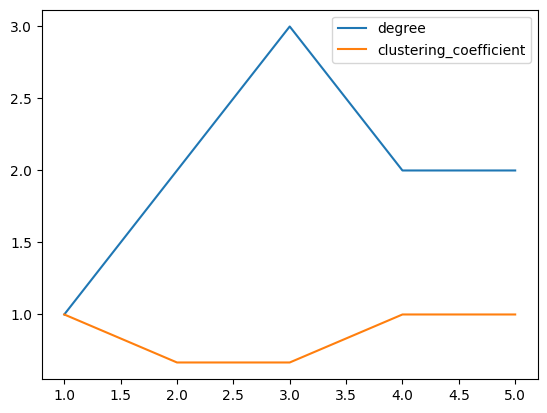

In [32]:
H.nodes.multi(["degree", "clustering_coefficient"]).aspandas().plot();

The `multi` method also accepts `NodeStat` objects, useful when passing arguments to each `NodeStat`, or when requesting attributes.

In [33]:
H.nodes.multi(["degree", H.nodes.degree(order=3), H.nodes.attrs("color")]).aspandas()

,degree,degree(order=3),attrs(color)
1,1,0,red
2,2,1,blue
3,3,1,yellow
4,2,1,red
5,2,1,blue


## Edge statistics

Every feature showcased above (lazy evaluation, type conversion, filtering, set operations, and multi objects) is supported for edge-quantity or edge-attribute mappings, via `EdgeStat` objects.

In [34]:
H.edges.order

EdgeStat('order')

In [35]:
H.edges.order.asdict()

{0: 2, 1: 3, 2: 2}

In [36]:
H.edges.filterby("order", 3)

EdgeView((1,))

In [37]:
H.edges.multi(["order", "size"]).aspandas()

,order,size
0,2,3
1,3,4
2,2,3


## User-defined statistics

Suppose during the course of your research you come up with a new node-level statistic. For the purpose of this tutorial, we are going to define a statistic called `user_degree`. The `user_degree` of a node is simply its standard degree times 10.

Since this is also a node-quantity mapping, we would like to give it the same interface as `degree` and all the other `NodeStat`s. The stats package provides a simple way to do this. Simply use the `nodestat_func` decorator.

In [38]:
@xgi.nodestat_func
def user_degree(net, bunch):
    """The user degree of a bunch of nodes in net."""
    return {n: 10 * net.degree(n) for n in bunch}

Now `user_degree` is a valid stat that can be computed on any hypergraph:

In [39]:
H.nodes.user_degree.asdict()

{1: 10, 2: 20, 3: 30, 4: 20, 5: 20}

Every single feature showcased above is available for use with `user_degree`, including filtering nodes and multi stats objects.

In [40]:
H.nodes.filterby("user_degree", 20)

NodeView((2, 4, 5))

In [41]:
H.nodes.multi(["degree", "user_degree"]).aspandas()

,degree,user_degree
1,1,10
2,2,20
3,3,30
4,2,20
5,2,20


The `@xgi.nodestat_func` decorator works on any function or callable that admits two parameters: `net` and `bunch`, where `net` is the network and `bunch` is an iterable of nodes in `net`. Additionally, the function must return a dictionary with pairs of the form `node: value`, where `node` is an element of `bunch`. The library will take care of type conversions, but the output value of this function must always be a dict.

User-defined edge statistics can similarly be defined using the `@xgi.edgestat` decorator.